# Abstract for the Project

## Task

The task is to test which model architecture performs best at imdb sentiment classification.

## Model

The models utilize BERT embeddings and various combinations of lstm , cnn , and graph techniques.

## Experiment

The experiments are in progress. We are looking for accuracy, failure points, and interpretability. The goal is to test for full data, limited data, and limited label scenarios.

## Datasets

The main dataset is the IMDB movie reviews and whatever was used to produce the BERT embeddings.

# Code

## Import statements

In [75]:
# !pip install -U tensorflow-text==2.8.1

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import neural_structured_learning as nsl
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text

# Resets notebook state
tf.keras.backend.clear_session()

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print(
    "GPU is",
    "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.8.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [3]:
import dataLoader
import bertEmbeddings
import tfRecordTools
import train
import importlib
import models

## Dataset Loading

In [4]:
# Load data from IMDB
imdb = tf.keras.datasets.imdb
(pp_train_data, pp_train_labels), (pp_test_data, pp_test_labels) = (
    imdb.load_data(num_words=10000))

In [5]:
# This block limits how much is loaded to keep debugging short
# don't run on the final experiments

limit = 5000

pp_train_data = pp_train_data[0:limit]
pp_train_labels = pp_train_labels[0:limit]
pp_test_data = pp_test_data[0:limit]
pp_test_labels = pp_test_labels[0:limit]

In [6]:
# Print data entries
print('Training entries: {}, labels: {}'.format(
    len(pp_train_data),
    len(pp_train_labels)
))
training_samples_count = len(pp_train_data)
print(pp_train_data[0])
len(pp_train_data[0]), len(pp_train_data[1])

Training entries: 5000, labels: 5000
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


(218, 189)

In [7]:
reverseWordIndex = dataLoader.buildReverseWordIndex(imdb)

In [8]:
dataLoader.decodeReview(pp_train_data[0], reverseWordIndex)

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

## Pretrained Embeddings

In [9]:
# Retrieve small bert embeddings
pretrained_embedding = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2'

In [10]:
# Preprocess and encode input
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
encoder_inputs = preprocessor(text_input)

encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2',trainable=True)

outputs = encoder(encoder_inputs)

pooled_output = outputs['pooled_output'] # [batch_size, 128].
# [batch_size, seq_length, 128].

sequence_output = outputs['sequence_output']

Metal device set to: Apple M1 Max


2022-05-22 12:01:09.635332: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-22 12:01:09.635442: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-05-22 12:01:10.352275: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-22 12:01:10.366063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [12]:
oneEmbedding = bertEmbeddings.createBertEmbeddingExample(pp_train_data[0], 0, reverseWordIndex, encoder, preprocessor)

2022-05-22 12:01:27.588390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-22 12:01:27.666678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [74]:
# oneEmbedding

In [14]:
# Generate full BERT embeddings

bertEmbeddingsPath = '/tmp/imdb/bertEmeddings.tfr'
bertEmbeddings.createBertEmbedding(pp_train_data, bertEmbeddingsPath, 0, reverseWordIndex, encoder, preprocessor)

5000

In [15]:
!wc -l {bertEmbeddingsPath}

   46663 /tmp/imdb/bertEmeddings.tfr


## Constructing the BERT Graph

In [16]:
pp_train_data.shape

(5000,)

In [17]:
bertGraphPath = '/tmp/imdb/bert_graph_99.tsv'

In [18]:
graph_builder_config = nsl.configs.GraphBuilderConfig(
    similarity_threshold=0.99,
    lsh_splits=32,
    lsh_rounds=15,
    random_seed=12345)

nsl.tools.build_graph_from_config([bertEmbeddingsPath],
                                  bertGraphPath,
                                  graph_builder_config)

In [19]:
!wc -l {bertGraphPath}

    1292 /tmp/imdb/bert_graph_99.tsv


## Sample Features

In [20]:
trainDataPath = '/tmp/imdb/train_data.tfr'
testDataPath = '/tmp/imdb/test_data.tfr'

In [21]:
next_record_id = train.createRecords(pp_train_data,
                                pp_train_labels,
                                trainDataPath,
                                0)
train.createRecords(pp_test_data,
               pp_test_labels,
               testDataPath,
               next_record_id)

10000

## Augment the training data using graphs

In [22]:
nslTrainPath = '/tmp/imdb/nsl_train_data.tfr'

In [24]:
nsl.tools.pack_nbrs(
    trainDataPath,
    '',
    bertGraphPath,
    nslTrainPath,
    add_undirected_edges=True,
    max_nbrs=3)

In [25]:
!wc -l {nslTrainPath}

  125355 /tmp/imdb/nsl_train_data.tfr


In [73]:
!wc -l {trainDataPath}

   87204 /tmp/imdb/train_data.tfr


## Training and Validation

### Training Hyperparameters

In [62]:
# Set parameters
NBR_FEATURE_PREFIX = 'NL_nbr_'
NBR_WEIGHT_SUFFIX = '_weight'

In [63]:
class HParams(object):
    """
    Hyperparameters used for training.
    """
    def __init__(self):
        # dataset parameters
        self.num_classes = 2
        self.max_seq_length = 256
        self.vocab_size = 10000
        # neural graph learning parameters
        self.distance_type = nsl.configs.DistanceType.L2
        self.graph_regularization_multiplier = 0.1
        self.num_neighbors = 2
        # model architecture
        self.num_embedding_dims = 16
        self.num_lstm_dims = 64
        self.num_fc_units = 64
        # training parameters
        self.train_epochs = 20
        self.batch_size = 128
        # eval parameters
        self.eval_steps = None  # All instances in the test set are evaluated.

In [64]:
HPARAMS = HParams()

### Build Traininig and Testing Datasets

In [65]:
# Create training and testing datasets
train_dataset = train.makeDataset(trainDataPath, HPARAMS, NBR_FEATURE_PREFIX, NBR_WEIGHT_SUFFIX, True)
test_dataset = train.makeDataset(testDataPath, HPARAMS, NBR_FEATURE_PREFIX, NBR_WEIGHT_SUFFIX, False)

### Build Validation Set

In [66]:
validation_fraction = 0.5
validation_size = int(validation_fraction *
                      int(training_samples_count / HPARAMS.batch_size))
print(validation_size)
validation_dataset = train_dataset.take(validation_size)
train_dataset = train_dataset.skip(validation_size)

19


## Setting up Base Models (Bi-LSTM)

### Create Models

In [67]:
# build Bi-LSTM model
tf.keras.backend.clear_session()
model = models.makeBilstmModel(HPARAMS)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 words (InputLayer)          [(None, 256)]             0         
                                                                 
 embedding (Embedding)       (None, 256, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              41472     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 209,793
Trainable params: 209,793
Non-trainable params: 0
_______________________________________________________

In [68]:
# set loss function and optimizer
model.compile(
    optimizer='rmsprop',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])

### Fit Model

In [69]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=HPARAMS.train_epochs,
    verbose=1)

Epoch 1/20


2022-05-22 12:09:29.658089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-22 12:09:29.926061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-22 12:09:29.940457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-22 12:09:30.505304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-22 12:09:30.520356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


     21/Unknown - 6s 194ms/step - loss: 0.6933 - accuracy: 0.4996

2022-05-22 12:09:35.563618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-22 12:09:35.643933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-22 12:09:35.651960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 8s 286ms/step - loss: 0.6933 - accuracy: 0.4996 - val_loss: 0.6948 - val_accuracy: 0.4844
Epoch 2/20
21/21 [==============================] - 4s 177ms/step - loss: 0.6928 - accuracy: 0.4833 - val_loss: 0.6852 - val_accuracy: 0.4926
Epoch 3/20
21/21 [==============================] - 4s 188ms/step - loss: 0.6851 - accuracy: 0.5008 - val_loss: 0.6506 - val_accuracy: 0.4889
Epoch 4/20
21/21 [==============================] - 4s 192ms/step - loss: 0.6119 - accuracy: 0.5826 - val_loss: 0.5510 - val_accuracy: 0.7726
Epoch 5/20
21/21 [==============================] - 4s 193ms/step - loss: 0.5508 - accuracy: 0.7508 - val_loss: 2.2254 - val_accuracy: 0.5670
Epoch 6/20
21/21 [==============================] - 4s 190ms/step - loss: 0.5263 - accuracy: 0.7878 - val_loss: 0.3141 - val_accuracy: 0.8795
Epoch 7/20
21/21 [==============================] - 4s 194ms/step - loss: 0.4607 - accuracy: 0.8146 - val_loss: 0.3341 - val_accuracy: 0.8849
Epoch 8/20
21/21 

### Evaluate Model

In [70]:
# evaluate model performance on test data
results = model.evaluate(test_dataset, steps=HPARAMS.eval_steps)
print(results)

2022-05-22 12:10:54.309550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-22 12:10:54.391284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-22 12:10:54.405833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 4s 71ms/step - loss: 0.6145 - accuracy: 0.8250
[0.6144622564315796, 0.8250000476837158]


### Plot Performance

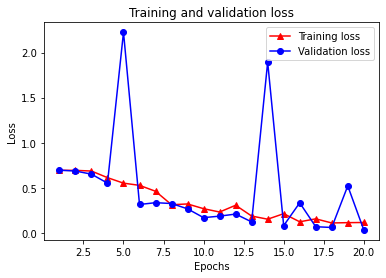

In [71]:
# plot training and validaiton loss over epochs
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "-r^" is for solid red line with triangle markers.
plt.plot(epochs, loss, '-r^', label='Training loss')
# "-b0" is for solid blue line with circle markers.
plt.plot(epochs, val_loss, '-bo', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.show()

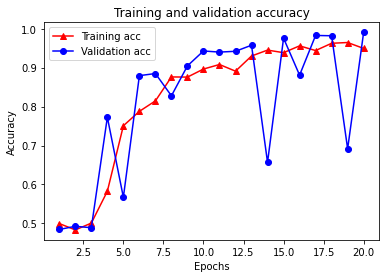

In [72]:
# plot training and validation accuracy over epochs
plt.clf()   # clear figure

plt.plot(epochs, acc, '-r^', label='Training acc')
plt.plot(epochs, val_acc, '-bo', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.show()

## CNN Models

### Same categories as before

## Graph Models

### Switch to the NSL augmernted data

### Same categories as before